In [16]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
import beam.calc.electron as ecalc
from lens import profile
from scipy.optimize import minimize
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]

In [17]:
# First lets define a function that takes an input waist location and halfwidth and return Bmag
def bmag(x):
    waist = x[0]
    hw = x[1]
    z0 = 1.5
    dz = 0.5
    betas = 0.10
    N = 1500
    sigma = hw/(np.sqrt(2*np.log(2)))
    beta0 = betas+(z0+waist)**2/betas
    alpha0 = (z0+waist)/betas
    gb0 = 20000
    ne0 = 0.5
    dgdz0 = 16.7e9/me/1e6
    dgdz0 = 0.0
    z, frac = profile.plasma_gaussian_ramps(z0, dz, sigma, sigma, N, z0)
    ne = frac*ne0
    beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
    kp = 5.95074e4 * np.sqrt(ne0)
    kb = kp/np.sqrt(2*gb[-1])
    Bmag = 0.5*(beta[-1]*kb+gamma[-1]/kb)
    return Bmag

x0 = [-0.25, 0.20]
res = minimize(bmag, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
print('Optimal waist: %0.6f, Optimal hw: %0.6f' % (res.x[0], res.x[1]))

Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 80
         Function evaluations: 156
Optimal waist: -0.384090, Optimal hw: 0.139480


In [18]:
hw = res.x[1]
waist = res.x[0]
z0 = 1.5
dz = 0.5
betas = 0.10
N = 3500
sigma = hw/(np.sqrt(2*np.log(2)))
beta0 = betas+(z0+waist)**2/betas
alpha0 = (z0+waist)/betas
gb0 = 20000
ne0 = 0.5
dgdz0 = 16.7e9/me/1e6
dgdz0 = 0.0
z, frac = profile.plasma_gaussian_ramps(z0, dz, sigma, sigma, N, 2*z0+dz)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

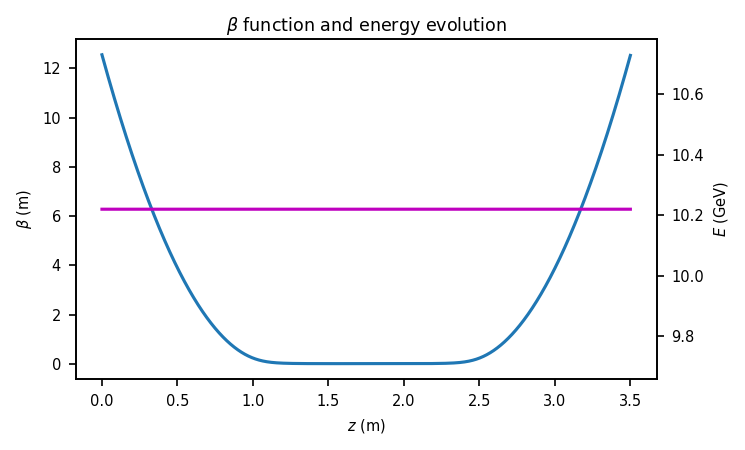

In [19]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(z, beta)
plt.title(r'$\beta$ function and energy evolution')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')
plt.twinx()
plt.plot(z, np.array(gb)*me*1e-3, 'm')
plt.ylabel(r'$E$ (GeV)')
plt.show()

In [20]:
M = 100
delta = np.linspace(-0.01, 0.01, M)
gb0A = 20000*(1+delta)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0, alpha0, gb0A[i],
                                                                                  dgdz0, ne0)

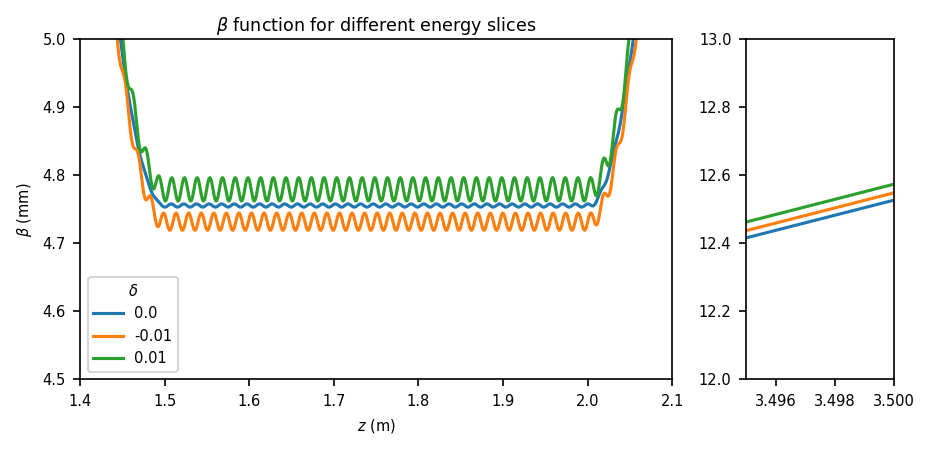

In [21]:
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.25])

plt.subplot(gs[0, 0])
plt.plot(z, np.array(beta)*1e3)
plt.plot(z, np.array(betaDelta[0, :])*1e3)
plt.plot(z, np.array(betaDelta[-1, :])*1e3)
plt.title(r'$\beta$ function for different energy slices')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')
plt.legend([0.0, delta[0], delta[-1]], title=r'$\delta$')
plt.xlim(1.4, 2.1)
plt.ylim(4.5, 5)

plt.subplot(gs[0, 1])
plt.plot(z, np.array(beta))
plt.plot(z, np.array(betaDelta[0, :]))
plt.plot(z, np.array(betaDelta[-1, :]))
plt.xlim(3.495, 3.5)
plt.ylim(12, 13)

plt.show()

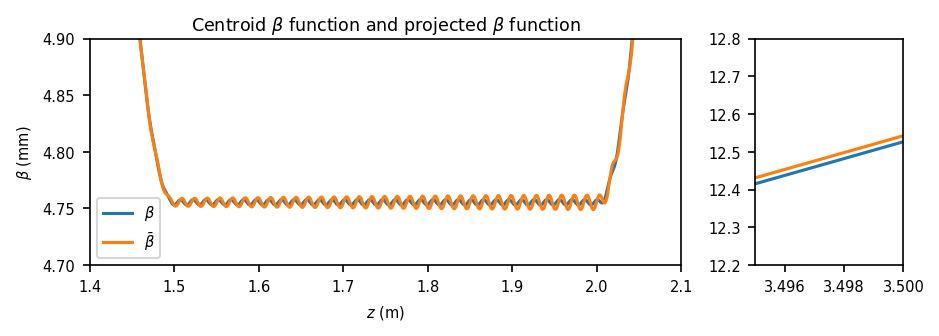

1.00000298958


In [22]:
# Calculated the projected beta function
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
plt.figure(figsize=(7, 2), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.25])

plt.subplot(gs[0, 0])
plt.plot(z, np.array(beta)*1e3)
plt.plot(z, betaP*1e3)
plt.title(r'Centroid $\beta$ function and projected $\beta$ function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')
plt.legend([r'$\beta$', r'$\bar{\beta}$'])
plt.xlim(1.4, 2.1)
plt.ylim(4.7, 4.9)

plt.subplot(gs[0, 1])
plt.plot(z, np.array(beta))
plt.plot(z, np.array(betaP))
plt.xlim(3.495, 3.5)
plt.ylim(12.2, 12.8)

plt.show()
print(np.sqrt(betaP[-1]*gammaP[-1]-alphaP[-1]**2))

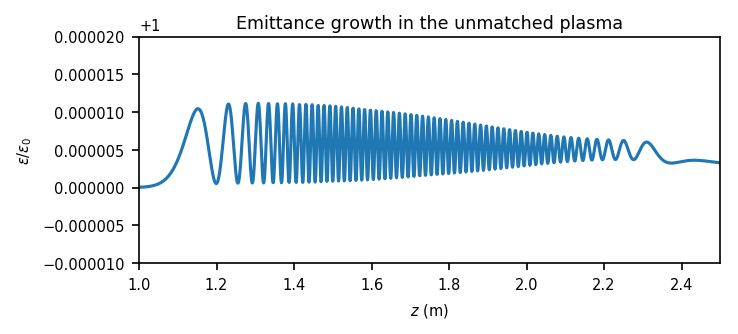

In [23]:
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
plt.figure(figsize=(5, 2), dpi=150)
plt.plot(z, eps)
plt.plot([0.0, 3.5], [1.434, 1.434], 'k--')
plt.title(r'Emittance growth in the unmatched plasma')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\epsilon/\epsilon_0$')
plt.xlim(1.0, 2.5)
plt.ylim(0.99999, 1.00002)
plt.show()

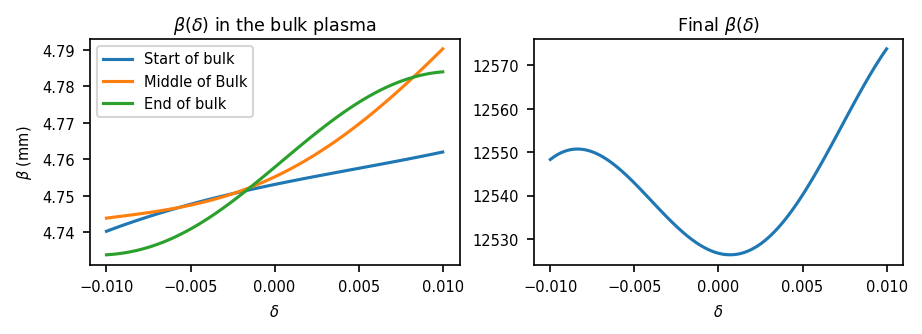

In [24]:
plt.figure(figsize=(7, 2), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.0])

plt.subplot(gs[0, 0])
plt.plot(delta, np.array(betaDelta[:, 1500])*1e3)
plt.plot(delta, np.array(betaDelta[:, 1750])*1e3)
plt.plot(delta, np.array(betaDelta[:, 2000])*1e3)
plt.legend(['Start of bulk', 'Middle of Bulk', 'End of bulk'])
plt.title(r'$\beta(\delta)$ in the bulk plasma')
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\beta$ (mm)')

plt.subplot(gs[0, 1])
plt.plot(delta, np.array(betaDelta[:, -1])*1e3)
plt.title(r'Final $\beta(\delta)$')
plt.xlabel(r'$\delta$')
plt.show()

In [25]:
# Let's look at a mismatched case
hw = res.x[1]
waist = res.x[0]+0.05
z0 = 1.5
dz = 0.5
betas = 0.10
N = 3500
sigma = hw/(np.sqrt(2*np.log(2)))
beta0 = betas+(z0+waist)**2/betas
alpha0 = (z0+waist)/betas
gb0 = 20000
ne0 = 0.5
dgdz0 = 16.7e9/me/1e6
dgdz0 = 0.0
z, frac = profile.plasma_gaussian_ramps(z0, dz, sigma, sigma, N, 2*z0+dz)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

M = 100
delta = np.linspace(-0.01, 0.01, M)
gb0A = 20000*(1+delta)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0, alpha0, gb0A[i],
                                                                                  dgdz0, ne0)

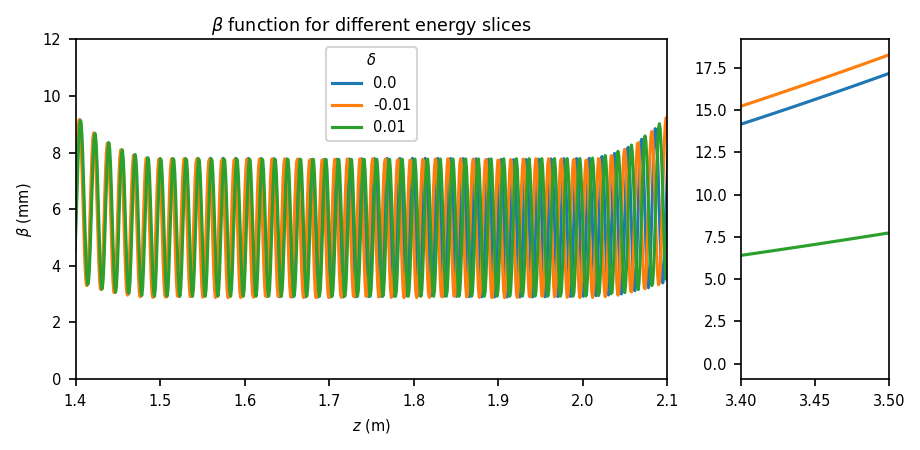

In [26]:
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.25])

plt.subplot(gs[0, 0])
plt.plot(z, np.array(beta)*1e3)
plt.plot(z, np.array(betaDelta[0, :])*1e3)
plt.plot(z, np.array(betaDelta[-1, :])*1e3)
plt.title(r'$\beta$ function for different energy slices')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')
plt.legend([0.0, delta[0], delta[-1]], title=r'$\delta$')
plt.xlim(1.4, 2.1)
plt.ylim(0, 12)

plt.subplot(gs[0, 1])
plt.plot(z, np.array(beta))
plt.plot(z, np.array(betaDelta[0, :]))
plt.plot(z, np.array(betaDelta[-1, :]))
plt.xlim(3.4, 3.5)
#plt.ylim(7.5, 18)

plt.show()

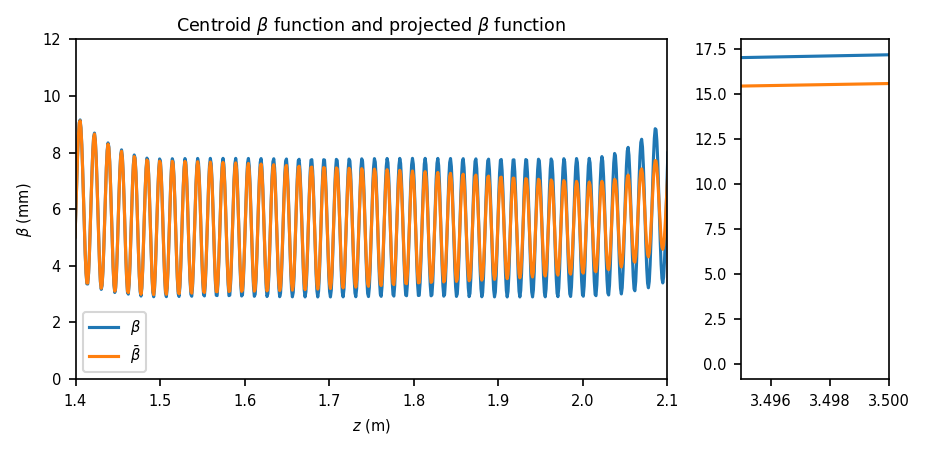

1.09721989975


In [27]:
# Calculated the projected beta function
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.25])

plt.subplot(gs[0, 0])
plt.plot(z, np.array(beta)*1e3)
plt.plot(z, betaP*1e3)
plt.title(r'Centroid $\beta$ function and projected $\beta$ function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')
plt.legend([r'$\beta$', r'$\bar{\beta}$'])
plt.xlim(1.4, 2.1)
plt.ylim(0, 12)

plt.subplot(gs[0, 1])
plt.plot(z, np.array(beta))
plt.plot(z, np.array(betaP))
plt.xlim(3.495, 3.5)
#plt.ylim(12, 13)

plt.show()
print(np.sqrt(betaP[-1]*gammaP[-1]-alphaP[-1]**2))

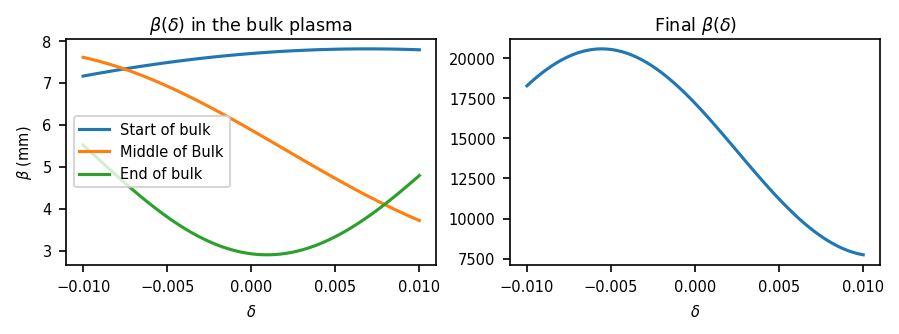

In [28]:
plt.figure(figsize=(7, 2), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.0])

plt.subplot(gs[0, 0])
plt.plot(delta, np.array(betaDelta[:, 1500])*1e3)
plt.plot(delta, np.array(betaDelta[:, 1750])*1e3)
plt.plot(delta, np.array(betaDelta[:, 2000])*1e3)
plt.legend(['Start of bulk', 'Middle of Bulk', 'End of bulk'])
plt.title(r'$\beta(\delta)$ in the bulk plasma')
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\beta$ (mm)')

plt.subplot(gs[0, 1])
plt.plot(delta, np.array(betaDelta[:, -1])*1e3)
plt.title(r'Final $\beta(\delta)$')
plt.xlabel(r'$\delta$')
plt.show()

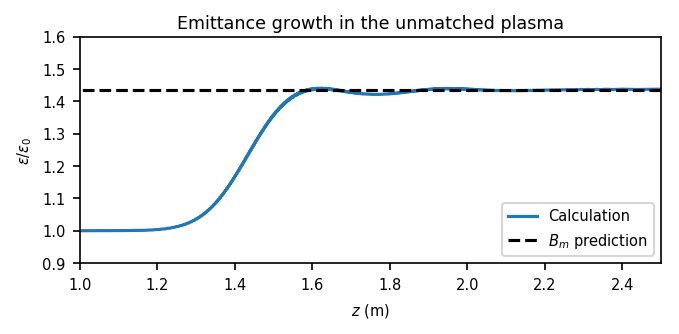

In [29]:
# Lets compare to the macroparticle simulation
hw = res.x[1]
waist = res.x[0]
z0 = 1.5
dz = 0.5
betas = 0.10
N = 3500
sigma = hw/(np.sqrt(2*np.log(2)))
beta0 = betas+(z0+waist)**2/betas
alpha0 = (z0+waist)/betas
gb0 = 20000
ne0 = 10
dgdz0 = 16.7e9/me/1e6
dgdz0 = 0.0
z, frac = profile.plasma_gaussian_ramps(z0, dz, sigma, sigma, N, 2*z0+dz)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

M = 100
delta = np.linspace(-0.01, 0.01, M)
gb0A = 20000*(1+delta)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0, alpha0, gb0A[i],
                                                                                  dgdz0, ne0)
    
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
plt.figure(figsize=(5, 2), dpi=150)
plt.plot(z, eps)
plt.plot([0.0, 3.5], [1.434, 1.434], 'k--')
plt.title(r'Emittance growth in the unmatched plasma')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\epsilon/\epsilon_0$')
plt.legend(['Calculation', '$B_m$ prediction'])
plt.xlim(1.0, 2.5)
plt.ylim(0.9, 1.6)
plt.show()

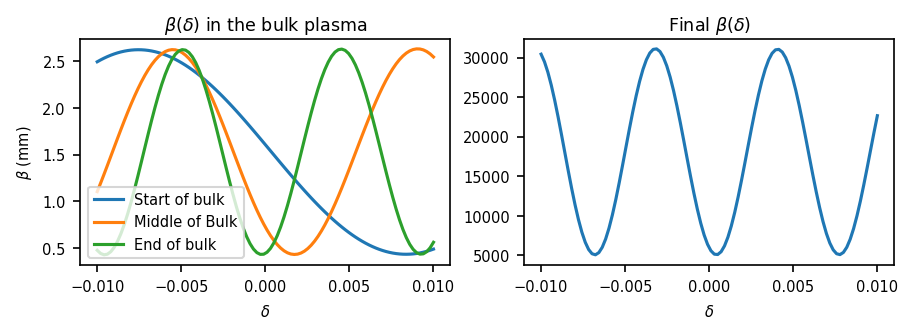

In [30]:
plt.figure(figsize=(7, 2), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.0])

plt.subplot(gs[0, 0])
plt.plot(delta, np.array(betaDelta[:, 1500])*1e3)
plt.plot(delta, np.array(betaDelta[:, 1750])*1e3)
plt.plot(delta, np.array(betaDelta[:, 2000])*1e3)
plt.legend(['Start of bulk', 'Middle of Bulk', 'End of bulk'])
plt.title(r'$\beta(\delta)$ in the bulk plasma')
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\beta$ (mm)')

plt.subplot(gs[0, 1])
plt.plot(delta, np.array(betaDelta[:, -1])*1e3)
plt.title(r'Final $\beta(\delta)$')
plt.xlabel(r'$\delta$')
plt.show()